# Emojitranslate project

## Part one - learning to predict emojis from tweets

The following code adapted from the Osinga deep learning cookbook - using the Twitter API to sample EN language tweets that contain exactly one emoji

In [246]:
import random
import twitter
import emoji
# import itertools
import pandas as pd
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#from sklearn.model_selection import train_test_split
from keras import Sequential, optimizers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
import keras.callbacks
from keras.backend import clear_session
#import json

import os
# import nb_utils
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalMaxPooling1D#, Merge 
from keras.models import Model
from keras.layers.merge import Concatenate, Average

# from gensim.models import Word2Vec

In [247]:
all_tweets = pd.read_csv('data/emojis_homemade.csv')
all_tweets['emoji'].value_counts()

/home/nick/anaconda3/envs/emojitranslate-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


😂        70866
😭        28812
❤        23972
emoji    16415
😍        15831
🔥        15568
🤣         9882
🙏         7845
😩         7839
💕         7483
🤔         7383
😊         6750
🖤         6194
✨         6092
👀         5923
💜         5901
👏         5669
🙄         5466
💀         5268
🙌         5224
🎉         5051
😘         4719
💯         4661
💙         4519
♥         4143
😔         4112
👍         4018
👇         3816
😉         3755
🚨         3652
         ...  
⏺            2
🀄            1
🔡            1
◀            1
🤾            1
🈳            1
🚟            1
🚋            1
🚇            1
🕦            1
📏            1
🛢            1
🕟            1
⚱            1
🚳            1
🧘            1
🧙            1
🈲            1
🕍            1
🕜            1
📤            1
👝            1
🈵            1
🗃            1
➗            1
🏬            1
🕠            1
🤼            1
🏣            1
㊗            1
Name: emoji, Length: 1086, dtype: int64

In [248]:
all_tweets.shape

(729680, 3)

In [249]:
all_tweets.head

<bound method NDFrame.head of        Unnamed: 0                                               text emoji
0               0  RT @mydear_bangtan: [VID] 181023 - Foi adicion...     ©
1               1  RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...     💫
2               2  RT @TrendsPrabhas: Now you are watching Indian...     😎
3               3                                    dats for keeps      💛
4               4  RT @xruiztru: WHO ARMS THE SAUDIS?\n\n  🇺🇸US 5...     🏳
5               5  RT @xxxfreaknasty2: interracial couple go at i...     🌝
6               6               @Eric_Deshaun Holy shit no I think.      😩
7               7     RT @fanmutuals: army, follow who retweet this      👑
8               8  RT @_Simplykpop: Simply K-Pop harddrive dump\n...     🤩
9               9  Happy birthday nellie @thelittlegend, hope you...     ❤
10             10  RT @montparnasty: "I have passed through fire"...     💕
11             11  RT @Jason_Mckeown: Look how empty Valley Parad...  

Now let's filter these to only include emojis with more than 1000 examples 

In [250]:
tweets = all_tweets.groupby('emoji').filter(lambda c:len(c) > 1000)
tweets['emoji'].value_counts()

😂        70866
😭        28812
❤        23972
emoji    16415
😍        15831
🔥        15568
🤣         9882
🙏         7845
😩         7839
💕         7483
🤔         7383
😊         6750
🖤         6194
✨         6092
👀         5923
💜         5901
👏         5669
🙄         5466
💀         5268
🙌         5224
🎉         5051
😘         4719
💯         4661
💙         4519
♥         4143
😔         4112
👍         4018
👇         3816
😉         3755
🚨         3652
         ...  
😄         1350
😇         1340
🔴         1333
🤤         1330
🌹         1327
⚡         1316
✔         1279
😜         1259
😐         1242
✈         1241
✊         1184
💦         1160
😑         1152
😴         1149
👊         1129
🙈         1127
😕         1125
❣         1105
😞         1088
💘         1065
⭐         1058
📽         1055
❗         1054
📍         1044
🔗         1044
🤯         1039
💫         1027
⚠         1022
🤞         1013
🌟         1012
Name: emoji, Length: 112, dtype: int64

In [251]:
# Now re-index the data frame
tweets.reset_index(inplace=True)

so how big is our potential training set?

In [252]:
len(tweets)

461544

What proportion of these are the most common emoji? (crying with laughter 😂)

In [253]:
tweets['emoji'].value_counts()[0]/sum(tweets['emoji'].value_counts())

0.15354115750610992

In [254]:
max(tweets['text'], key=lambda t:len(t))

'RT @JoanKareri: A guy who smells good and leaves you with his scent after he leaves&gt;&gt;&gt;&gt; &gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;'

In [255]:
chars = list(sorted(set(chain(*tweets['text']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in tweets['text'])

emojis = list(sorted(set(tweets['emoji'])))
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
emojis[:10]

#train_tweets, test_tweets = train_test_split(tweets, test_size=0.1)

['emoji', '©', '‼', '▶', '☹', '☺', '♥', '⚠', '⚡', '✅']

Currently we've collected quite a lot of tweet data, so to speed up the prototyping of the model we're going to create a train/dev/test datasets of 10,000 tweets each.

In [256]:
#train_tweets = tweets[0:10000]
#dev_tweets = tweets[10000:20000]
#test_tweets = tweets[20000:30000]


# !! Temp! Try on much bigger dataset
#train_tweets = tweets[0:100000] # 100000 tweets
#dev_tweets = tweets[100000:110000]
#test_tweets = tweets[110000:120000]

# Try on 400k tweets
train_tweets = tweets[0:400000] # 100000 tweets
dev_tweets = tweets[400000:420000]
test_tweets = tweets[420000:440000]


In [257]:
#def data_generator(tweets, batch_size):
#    while True:
#        if batch_size is None:
#            batch = tweets
#            batch_size = batch.shape[0]
#        else:
#            batch = tweets.sample(batch_size)
#        X = np.zeros((batch_size, max_sequence_len, len(chars)))
#        y = np.zeros((batch_size,))
#        for row_idx, (_, row) in enumerate(batch.iterrows()):
#            y[row_idx] = emoji_to_idx[row['emoji']]
#            for ch_idx, ch in enumerate(row['text']):
#                X[row_idx, ch_idx, char_to_idx[ch]] = 1
#        yield X, y
#
#next(data_generator(tweets, 10))

In [258]:
#def create_char_cnn_model(num_chars, max_sequence_len, num_labels):
#    char_input = Input(shape=(max_sequence_len, num_chars), name='char_cnn_input')
#    
#    conv_1x = Conv1D(128, 6, activation='relu', padding='valid')(char_input)
#    max_pool_1x = MaxPooling1D(4)(conv_1x)
#    conv_2x = Conv1D(256, 6, activation='relu', padding='valid')(max_pool_1x)
#    max_pool_2x = MaxPooling1D(4)(conv_2x)

#    flatten = Flatten()(max_pool_2x)
#    dense = Dense(128, activation='relu')(flatten)
#    preds = Dense(num_labels, activation='softmax', name='char_cnn_predictions')(dense)

#    model = Model(char_input, preds)
#    model.compile(loss='sparse_categorical_crossentropy',
#                  optimizer='rmsprop',
#                  metrics=['acc'])
#    return model

#char_cnn_model = create_char_cnn_model(len(char_to_idx), max_sequence_len, len(emojis))
#char_cnn_model.summary()

In [259]:
#early = keras.callbacks.EarlyStopping(monitor='loss',
#                              min_delta=0.03,
#                              patience=2,
#                              verbose=1, mode='auto')

#checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_cnn.h5',
#                                             monitor='val_acc',
#                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                         histogram_freq=1,
#                                         embeddings_freq=1)

#BATCH_SIZE = 512
#char_cnn_model.fit_generator(
#    data_generator(train_tweets, batch_size=BATCH_SIZE),
#    validation_data = data_generator(dev_tweets, batch_size=BATCH_SIZE),
#    validation_steps=int(dev_tweets.shape[0]/BATCH_SIZE),
#    epochs=5,
#    steps_per_epoch=len(train_tweets) / BATCH_SIZE,
#    verbose=1, # was: verbose=2
#    callbacks=[early, checkpoint]
#)

In [260]:
#pd.options.display.max_colwidth = 128
#inspect_tweets = dev_tweets.sample(100)
#predicted = char_cnn_model.predict_generator(data_generator(inspect_tweets, batch_size=None), steps=1)
#show = pd.DataFrame({
#    'text': inspect_tweets['text'],
#    'true': inspect_tweets['emoji'],
#    'pred': [emojis[np.argmax(x)] for x in predicted],
#})
#show = show[['text', 'true', 'pred']]
#show.head(10)

# Simple neural network - single Dense layer

Benchmark performance with the simplest neural network we can get

Let's divide up the train/dev/test sets so we're not relying on a generator

In [262]:
x_train = train_tweets["text"]
y_train = np.asarray(train_tweets["emoji"])
x_dev = dev_tweets["text"]
y_dev = np.asarray(dev_tweets["emoji"])
x_test = test_tweets["text"]
y_test = np.asarray(test_tweets["emoji"])

all_emojis = np.concatenate((y_train, y_dev, y_test), axis=0)

emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
#emojis[:10]

all_emojis_idx = np.zeros(all_emojis.shape[0])

for i in range (all_emojis.shape[0]):
    all_emojis_idx[i] = emoji_to_idx[all_emojis[i]]    

all_emojis_one_hot = to_categorical (all_emojis_idx)
    
#y_train_idx = all_emojis_one_hot[0:10000,:]
#y_dev_idx = all_emojis_one_hot[10000:20000,:]
#y_test_idx = all_emojis_one_hot[20000:30000,:]


# Temp!
#y_train_idx = all_emojis_one_hot[0:100000,:]
#y_dev_idx = all_emojis_one_hot[100000:110000,:]
#y_test_idx = all_emojis_one_hot[110000:120000,:]


# Temp!
y_train_idx = all_emojis_one_hot[0:400000,:]
y_dev_idx = all_emojis_one_hot[400000:420000,:]
y_test_idx = all_emojis_one_hot[420000:440000,:]

In [263]:
# y_train_idx[0:10]

Now let's start by one-hot encoding the text samples

In [264]:
num_words = 5000


tokenizer = Tokenizer(num_words = num_words) # was: 1000
tokenizer.fit_on_texts (x_train)

#x_train_sequences = tokenizer.texts_to_sequences(x_train)
#x_dev_sequences = tokenizer.texts_to_sequences(x_dev)
#x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_one_hot = tokenizer.texts_to_matrix(x_train, mode='binary')
x_dev_one_hot = tokenizer.texts_to_matrix(x_dev, mode='binary')
x_test_one_hot = tokenizer.texts_to_matrix(x_test, mode='binary')




# remember to pad sequences

In [265]:
x_train_one_hot.shape

(400000, 5000)

In [266]:
y_train_idx.shape

(400000, 112)

In [267]:
tokenizer.word_index

{'rt': 1,
 'https': 2,
 't': 3,
 'co': 4,
 'the': 5,
 'i': 6,
 'to': 7,
 'you': 8,
 'a': 9,
 'and': 10,
 'this': 11,
 'my': 12,
 'is': 13,
 'for': 14,
 'of': 15,
 'in': 16,
 'it': 17,
 'me': 18,
 'on': 19,
 'so': 20,
 'that': 21,
 'with': 22,
 '️': 23,
 'be': 24,
 'love': 25,
 'bts': 26,
 'your': 27,
 'at': 28,
 'all': 29,
 'like': 30,
 'we': 31,
 'are': 32,
 'just': 33,
 'was': 34,
 'text': 35,
 'twt': 36,
 'if': 37,
 'but': 38,
 'i’m': 39,
 'have': 40,
 'not': 41,
 'now': 42,
 'amp': 43,
 'he': 44,
 'up': 45,
 'when': 46,
 'one': 47,
 'u': 48,
 'get': 49,
 'who': 50,
 'thank': 51,
 'out': 52,
 'what': 53,
 'do': 54,
 'from': 55,
 'how': 56,
 'no': 57,
 '…': 58,
 'they': 59,
 'will': 60,
 'good': 61,
 'back': 62,
 'can': 63,
 'time': 64,
 'got': 65,
 'new': 66,
 'happy': 67,
 'see': 68,
 'day': 69,
 'about': 70,
 'know': 71,
 'his': 72,
 'go': 73,
 'her': 74,
 'as': 75,
 'too': 76,
 'follow': 77,
 'more': 78,
 'our': 79,
 'has': 80,
 '1': 81,
 'don’t': 82,
 'by': 83,
 'best': 84,
 'he

# A linear classifier

As a performance baseline for more complex models, it's instructive to see how well we can do with just a linear classifier with no hidden layer. With 64 hidden units trained on 10,000 training examples, we're able to get up to about 38% accuracy on the validation set. A lower learning rate slows down the learning (although it's still very fast) but doesn't appear to do any better in terms of final accuracy before the model starts overfitting. 

In [268]:
y_dev_idx.shape

(20000, 112)

In [271]:
output_size = y_dev_idx.shape[1] # around 64 units for 10,000 tweets

model = Sequential()
model.add(Dense(output_size, activation='softmax', input_shape=(num_words,))) 
model.compile(optimizer=optimizers.RMSprop(lr = 0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 8192,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    verbose=2)

Train on 400000 samples, validate on 20000 samples
Epoch 1/20
 - 8s - loss: 3.8133 - acc: 0.2778 - top_k_categorical_accuracy: 0.4964 - val_loss: 3.4997 - val_acc: 0.3081 - val_top_k_categorical_accuracy: 0.5225
Epoch 2/20
 - 7s - loss: 3.1411 - acc: 0.3623 - top_k_categorical_accuracy: 0.5888 - val_loss: 3.1989 - val_acc: 0.3453 - val_top_k_categorical_accuracy: 0.5600
Epoch 3/20
 - 7s - loss: 2.8132 - acc: 0.4018 - top_k_categorical_accuracy: 0.6345 - val_loss: 3.0290 - val_acc: 0.3665 - val_top_k_categorical_accuracy: 0.5814
Epoch 4/20
 - 7s - loss: 2.5948 - acc: 0.4282 - top_k_categorical_accuracy: 0.6631 - val_loss: 2.9229 - val_acc: 0.3781 - val_top_k_categorical_accuracy: 0.5928
Epoch 5/20
 - 7s - loss: 2.4378 - acc: 0.4478 - top_k_categorical_accuracy: 0.6821 - val_loss: 2.8545 - val_acc: 0.3850 - val_top_k_categorical_accuracy: 0.6017
Epoch 6/20
 - 7s - loss: 2.3213 - acc: 0.4627 - top_k_categorical_accuracy: 0.6971 - val_loss: 2.8146 - val_acc: 0.3937 - val_top_k_categorical_

In [272]:
import matplotlib.pyplot as plt

def plot_train_history(history): 

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot (epochs, acc, 'bo', label='Training acc')
    plt.plot (epochs, val_acc, 'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

best validation accuracy:  0.4080000009059906


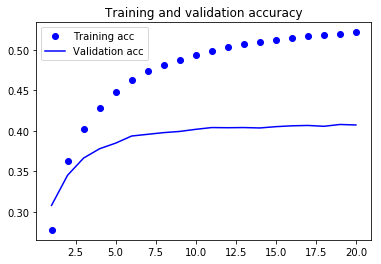

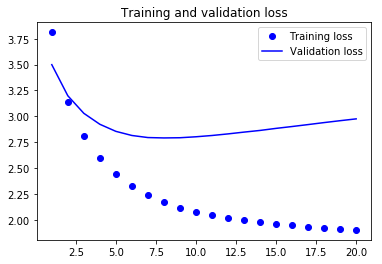

In [273]:
print ("best validation accuracy: ", max(history.history['val_acc']))
plot_train_history(history)

# Shallow neural network
A simple shallow neural network with a layer of hidden units

128 hidden units gets us up to 39% accuracy

Train on 400000 samples, validate on 20000 samples
Epoch 1/30
400000/400000 [==============================] - 8s 19us/step - loss: 3.7586 - acc: 0.2814 - top_k_categorical_accuracy: 0.4606 - val_loss: 3.3788 - val_acc: 0.3152 - val_top_k_categorical_accuracy: 0.5064
Epoch 2/30
400000/400000 [==============================] - 6s 16us/step - loss: 2.9719 - acc: 0.3751 - top_k_categorical_accuracy: 0.5717 - val_loss: 2.9438 - val_acc: 0.3551 - val_top_k_categorical_accuracy: 0.5643
Epoch 3/30
400000/400000 [==============================] - 6s 16us/step - loss: 2.6519 - acc: 0.4108 - top_k_categorical_accuracy: 0.6217 - val_loss: 2.7782 - val_acc: 0.3697 - val_top_k_categorical_accuracy: 0.5898
Epoch 4/30
400000/400000 [==============================] - 6s 16us/step - loss: 2.5031 - acc: 0.4334 - top_k_categorical_accuracy: 0.6457 - val_loss: 2.7145 - val_acc: 0.3810 - val_top_k_categorical_accuracy: 0.5990
Epoch 5/30
400000/400000 [==============================] - 6s 16us/step - loss: 

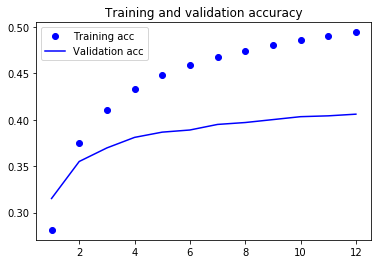

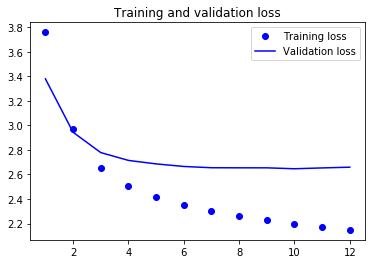

best validation accuracy:  0.4060000012397766


In [277]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(num_words,)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 30,
                    batch_size = 4096,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks = [early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

# Two layers of hidden units
A slight improvement over one layer of hidden units (<1%)

Train on 400000 samples, validate on 20000 samples
Epoch 1/30
400000/400000 [==============================] - 9s 24us/step - loss: 3.7312 - acc: 0.2894 - top_k_categorical_accuracy: 0.4844 - val_loss: 3.3255 - val_acc: 0.3253 - val_top_k_categorical_accuracy: 0.5312
Epoch 2/30
400000/400000 [==============================] - 8s 20us/step - loss: 2.9927 - acc: 0.3870 - top_k_categorical_accuracy: 0.5946 - val_loss: 3.0547 - val_acc: 0.3564 - val_top_k_categorical_accuracy: 0.5766
Epoch 3/30
400000/400000 [==============================] - 8s 20us/step - loss: 2.7913 - acc: 0.4117 - top_k_categorical_accuracy: 0.6224 - val_loss: 2.9577 - val_acc: 0.3718 - val_top_k_categorical_accuracy: 0.5873
Epoch 4/30
400000/400000 [==============================] - 8s 20us/step - loss: 2.6826 - acc: 0.4264 - top_k_categorical_accuracy: 0.6359 - val_loss: 2.8968 - val_acc: 0.3771 - val_top_k_categorical_accuracy: 0.5949
Epoch 5/30
400000/400000 [==============================] - 8s 20us/step - loss: 

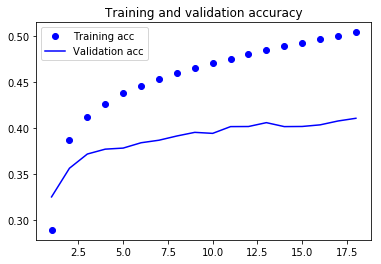

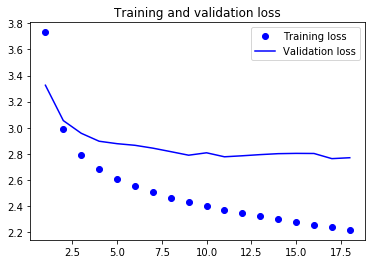

best validation accuracy:  0.410700000667572


In [282]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dense(128, activation='relu', 
                kernel_regularizer = regularizers.l2(0.0025)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 30,
                    batch_size = 4096,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## Two layer network with dropout and regularization

Takes longer to train than the network with neither. Some improvements in accuracy but it's a bit marginal.

Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - 2s 20us/step - loss: 3.7457 - acc: 0.2644 - val_loss: 3.2722 - val_acc: 0.3384
Epoch 2/30
100000/100000 [==============================] - 1s 14us/step - loss: 3.1097 - acc: 0.3592 - val_loss: 2.9690 - val_acc: 0.3792
Epoch 3/30
100000/100000 [==============================] - 1s 14us/step - loss: 2.8765 - acc: 0.3946 - val_loss: 2.8439 - val_acc: 0.4012
Epoch 4/30
100000/100000 [==============================] - 1s 13us/step - loss: 2.7427 - acc: 0.4154 - val_loss: 2.7601 - val_acc: 0.4136
Epoch 5/30
100000/100000 [==============================] - 1s 13us/step - loss: 2.6477 - acc: 0.4312 - val_loss: 2.7403 - val_acc: 0.4128
Epoch 6/30
100000/100000 [==============================] - 2s 16us/step - loss: 2.5791 - acc: 0.4414 - val_loss: 2.6828 - val_acc: 0.4228
Epoch 7/30
100000/100000 [==============================] - 1s 13us/step - loss: 2.5186 - acc: 0.4523 - val_loss: 2

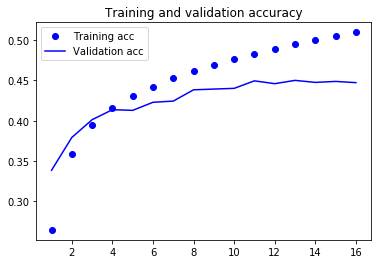

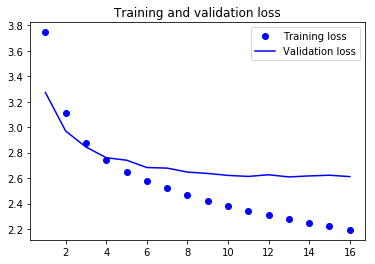

In [28]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu',
                kernel_regularizer = regularizers.l2(0.002)))
model.add(Dropout(0.4))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 30,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks=[early])

plot_train_history(history)

In [29]:
print ("best validation accuracy: ", max(history.history['val_acc']))

best validation accuracy:  0.45


# Embedding Layer

First of all, let's try just an embedding layer, into a classifier

In [283]:
x_train[0]

'RT @mydear_bangtan: [VID] 181023 - Foi adicionada a letra “D” no outdoor misterioso do #BTS em Hollywood.\nFormando: BTS AND... \n\n ILOVEPAR…'

Let's assume a maximum sequence length of 25 (shorter sequences will be padded out to this length with zeros)

In [373]:
maxlen = 25

In [374]:
# Tokenize the tweets into lists of words



def convert_to_sequences(tweet_text, tokenizer, maxlen=20):
    tweet_sequence = np.asarray(tokenizer.texts_to_sequences(tweet_text))
    padded = pad_sequences (tweet_sequence, maxlen=maxlen)
    return (padded)

x_train_sequences_1 = convert_to_sequences(x_train, tokenizer, maxlen=maxlen)
x_dev_sequences_1 = convert_to_sequences(x_dev, tokenizer, maxlen=maxlen)
x_test_sequences_1 = convert_to_sequences(x_test, tokenizer, maxlen=maxlen)

Let's inspect the process of turning tweets into integer (word token) sequences.

In [375]:
print ("x_train_sequences_1.shape:", x_train_sequences_1.shape)
print ("x_train_sequences_1[0,:]", x_train_sequences_1[0,:])
print ("average number of tokenized words per tweet:", np.count_nonzero(x_train_sequences_1, axis=1).mean())

x_train_sequences_1.shape: (400000, 25)
x_train_sequences_1[0,:] [   0    0    0    0    0    0    0    0    0    0    0    0    0    1
 3183 1512 3545    9   57   54   26 1041 3911   26   10]
average number of tokenized words per tweet: 11.0151225


In [376]:
n_output_classes = y_dev_idx.shape[1]

def simple_embedding_model(num_words, n_output_classes, n_embedding_dims = 16, max_sequence_length = 20):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 

    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'top_k_categorical_accuracy'])

    return (model)

Train on 400000 samples, validate on 20000 samples
Epoch 1/30
400000/400000 [==============================] - 1s 2us/step - loss: 3.7430 - acc: 0.2252 - top_k_categorical_accuracy: 0.4151 - val_loss: 3.4498 - val_acc: 0.2654 - val_top_k_categorical_accuracy: 0.4568
Epoch 2/30
400000/400000 [==============================] - 1s 2us/step - loss: 3.1115 - acc: 0.3352 - top_k_categorical_accuracy: 0.5219 - val_loss: 3.1165 - val_acc: 0.3239 - val_top_k_categorical_accuracy: 0.5211
Epoch 3/30
400000/400000 [==============================] - 1s 2us/step - loss: 2.8192 - acc: 0.3806 - top_k_categorical_accuracy: 0.5788 - val_loss: 2.9599 - val_acc: 0.3452 - val_top_k_categorical_accuracy: 0.5484
Epoch 4/30
400000/400000 [==============================] - 1s 2us/step - loss: 2.6496 - acc: 0.4112 - top_k_categorical_accuracy: 0.6110 - val_loss: 2.8701 - val_acc: 0.3673 - val_top_k_categorical_accuracy: 0.5666
Epoch 5/30
400000/400000 [==============================] - 1s 3us/step - loss: 2.529

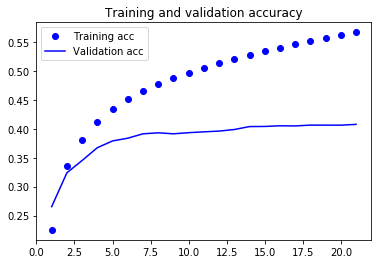

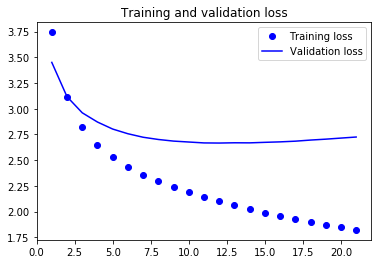

In [354]:
clear_session()

model = simple_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 100, 
                               max_sequence_length = maxlen)    

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')

#checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding.h5',
#                                             monitor='val_acc',
#                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                          #write_grads=1,
#                                          #histogram_freq=1,
#                                          embeddings_freq=1,
#                                          embeddings_data='embedding') ## ?? How to implement this

history = model.fit (x_train_sequences_1, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 30,
                     batch_size = 4096,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)

In [292]:
print ("best validation accuracy: ", max(history.history['val_acc']))

best validation accuracy:  0.41274999861717226


In [293]:
def deeper_embedding_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           dense2_size = 16,
                           dropout2_rate = 0.2,
                           lambd = 0.0):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 
    
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    model.add(Dense(dense2_size, activation='relu',
                    kernel_regularizer = regularizers.l2(lambd)))
    model.add(Dropout(dropout2_rate))
    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

Train on 400000 samples, validate on 20000 samples
Epoch 1/50
400000/400000 [==============================] - 1s 3us/step - loss: 4.2034 - acc: 0.1341 - val_loss: 3.7476 - val_acc: 0.2255
Epoch 2/50
400000/400000 [==============================] - 1s 2us/step - loss: 3.6532 - acc: 0.2309 - val_loss: 3.4535 - val_acc: 0.2500
Epoch 3/50
400000/400000 [==============================] - 1s 2us/step - loss: 3.4270 - acc: 0.2557 - val_loss: 3.3096 - val_acc: 0.2707
Epoch 4/50
400000/400000 [==============================] - 1s 2us/step - loss: 3.2855 - acc: 0.2742 - val_loss: 3.2335 - val_acc: 0.2964
Epoch 5/50
400000/400000 [==============================] - 1s 2us/step - loss: 3.1803 - acc: 0.2908 - val_loss: 3.1489 - val_acc: 0.3082
Epoch 6/50
400000/400000 [==============================] - 1s 2us/step - loss: 3.1032 - acc: 0.3021 - val_loss: 3.1055 - val_acc: 0.3146
Epoch 7/50
400000/400000 [==============================] - 1s 2us/step - loss: 3.0381 - acc: 0.3135 - val_loss: 3.1016 -

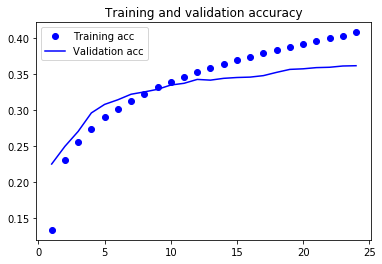

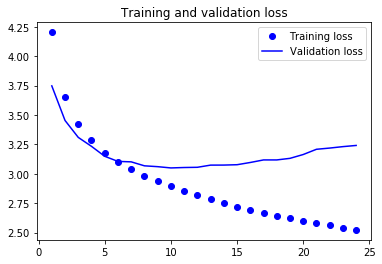

best validation accuracy:  0.3618500012397766


In [295]:
clear_session()

model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 128, 
                               max_sequence_length = maxlen,
                               lambd = 0.0006)    

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences_1, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 4096,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

Conclusions:
The embedding->shallow NN model struggles to get above 31% accuracy. Actually best results obtained when number of embedding dimensions is small: ~3-4. 

# Using pretrained (GloVe) word embeddings

In [377]:
# A utility function to load in the GloVe word/index/vector embeddings

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map, words

In [378]:
#Load the pretrained embeddings
# 400,001 words (0-400000), 50 dimensions  

#word_to_index, index_to_word, word_to_vec_map, words = read_glove_vecs('glove.6B.50d.txt')
#word_to_index, index_to_word, word_to_vec_map, words = read_glove_vecs('../embeddings/GloVe/twitter/glove.twitter.27B.50d.txt')
word_to_index, index_to_word, word_to_vec_map, words = read_glove_vecs('../embeddings/GloVe/twitter/glove.twitter.27B.100d.txt')

In [379]:
# Clean up corrupted rows in the downloaded encodings

#wrong_length = [word for (word, vec) in word_to_vec_map.items() if len(vec) != 50]
wrong_length = [word for (word, vec) in word_to_vec_map.items() if len(vec) != 100]
for w in wrong_length:
    del word_to_vec_map[w]
    i = word_to_index[w]
    del index_to_word[i]
    del word_to_index[w]
    words.remove(w)
    
    
print (word_to_vec_map['hello'].shape)
print (len(word_to_vec_map))
print (len(index_to_word))
print (len(word_to_index))
print (len(words))

(100,)
1193513
1193513
1193513
1193513


In [380]:
#Re-tokenize the tweets using the GloVe encodings. 

def sentences_to_indices(X, word_to_index, recognised_words, max_len):
    """
    Converts a pandas DataSeries of strings into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- pandas Series of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    recognised_words -- the set of the words in the trained embeddings
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros(shape=(m, max_len))
    
    X_items = X.iteritems()
    
    for i, item in enumerate (X_items):             # iterate over the series
        _, sentence = item                      # unpack the zip

        # convert list of sentence words to a list of indices
        indices_list = [word_to_index[word] for word in sentence.lower().split() if word in recognised_words]
    
        # assign first max_len items to the array
        for j, index in enumerate(indices_list[0:max_len]):
            X_indices[i,j] = index
        
    return X_indices

In [381]:
X1 = x_train
X1_indices = sentences_to_indices(X1,word_to_index, words, max_len = 8)
print("X1 =", X1[0:9])
print("X1_indices =", X1_indices[0:9])

X1 = 0    RT @mydear_bangtan: [VID] 181023 - Foi adicion...
1    RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...
2    RT @TrendsPrabhas: Now you are watching Indian...
3                                      dats for keeps 
4                 @Eric_Deshaun Holy shit no I think. 
5       RT @fanmutuals: army, follow who retweet this 
6    RT @_Simplykpop: Simply K-Pop harddrive dump\n...
7    Happy birthday nellie @thelittlegend, hope you...
8    RT @montparnasty: "I have passed through fire"...
Name: text, dtype: object
X1_indices = [[525980.   1743. 210491.   9493.   2115. 339211. 422256. 457066.]
 [525980. 324024. 657875. 576524. 629774. 337426. 127475.  40807.]
 [525980. 425660. 668738.  34878. 649202. 275332. 580716. 655002.]
 [137837. 211804. 310525.      0.      0.      0.      0.      0.]
 [260682. 553084. 422256. 266801.      0.      0.      0.      0.]
 [525980. 210824. 653091. 518841. 602844.      0.      0.      0.]
 [525980. 557140. 300853. 250058. 169198.      0.      0.  

Now let's tokenize the training set using the pretrained maps:

In [384]:
X_train_indices = sentences_to_indices(x_train, word_to_index, words, maxlen)
print ("average number of tokenized words per tweet:", np.count_nonzero(X_train_indices, axis=1).mean())
X_dev_indices = sentences_to_indices(x_dev, word_to_index, words, maxlen)
# Y_train_oh = convert_to_one_hot(Y_train, C = 5)

average number of tokenized words per tweet: 8.6065975


In [385]:
# Create an embedding layer to use the 50-dimensional GloVe vectors
def pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable_word_vectors=False):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1 + 1              # adding 1 to fit Keras embedding (requirement)
                                                        # also adding 1 because max index is len(word_to_index) +1 because
                                                        # we deleted an item
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    print ("emb matrix:", vocab_len, "x", emb_dim)
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    print ("len word_to_index:", len(word_to_index.items()))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable.
    embedding_layer = Embedding(input_dim = vocab_len, output_dim=emb_dim, trainable=trainable_word_vectors)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [386]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable_word_vectors=True)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

emb matrix: 1193515 x 100
len word_to_index: 1193513
weights[0][1][3] = 0.21751


# Todo - here should do prediction based on averaging the word vectors

## First - Simple (shallow) Embedding model using GloVe encodings

In [396]:
def simple_pretrained_embedding_model(input_shape, n_output_classes, n_embedding_dims = 100, max_sequence_length = 20):

    sentence_indices = Input(input_shape, name="input", dtype="int32")
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable_word_vectors=True)
    
    # Propagate sentence_indices through embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = Flatten()(embeddings)
    X = Dense(n_output_classes, activation=None)(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model
    
    
    return (model)

In [397]:
clear_session()

model = simple_pretrained_embedding_model((maxlen,),
                               n_output_classes, 
                               n_embedding_dims = 100, 
                               max_sequence_length = maxlen)    

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy'])

model.summary()


early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')

#checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding.h5',
#                                             monitor='val_acc',
#                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                          #write_grads=1,
#                                          #histogram_freq=1,
#                                          embeddings_freq=1,
#                                          embeddings_data='embedding') ## ?? How to implement this

emb matrix: 1193515 x 100
len word_to_index: 1193513
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 100)           119351500 
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               280112    
_________________________________________________________________
activation_1 (Activation)    (None, 112)               0         
Total params: 119,631,612
Trainable params: 119,631,612
Non-trainable params: 0
_________________________________________________________________


/home/nick/anaconda3/envs/emojitranslate-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 119351500 elements. This may consume a large amount of memory.
  num_elements)


Train on 400000 samples, validate on 20000 samples
Epoch 1/30
400000/400000 [==============================] - 8s 19us/step - loss: 3.5722 - acc: 0.2364 - top_k_categorical_accuracy: 0.4382 - val_loss: 3.3232 - val_acc: 0.2834 - val_top_k_categorical_accuracy: 0.4909
Epoch 2/30
400000/400000 [==============================] - 6s 15us/step - loss: 2.9901 - acc: 0.3431 - top_k_categorical_accuracy: 0.5499 - val_loss: 3.1673 - val_acc: 0.3102 - val_top_k_categorical_accuracy: 0.5123
Epoch 3/30
400000/400000 [==============================] - 6s 15us/step - loss: 2.7992 - acc: 0.3772 - top_k_categorical_accuracy: 0.5842 - val_loss: 3.0996 - val_acc: 0.3272 - val_top_k_categorical_accuracy: 0.5353
Epoch 4/30
400000/400000 [==============================] - 6s 15us/step - loss: 2.6686 - acc: 0.4019 - top_k_categorical_accuracy: 0.6085 - val_loss: 3.0608 - val_acc: 0.3444 - val_top_k_categorical_accuracy: 0.5444
Epoch 5/30
400000/400000 [==============================] - 6s 15us/step - loss: 

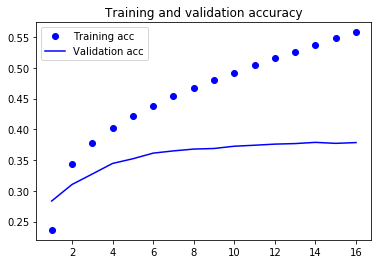

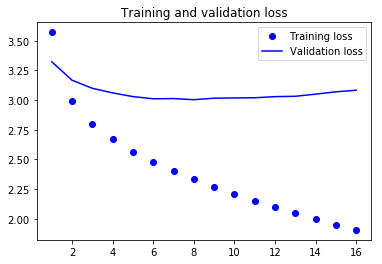

In [398]:
history = model.fit (X_train_indices, y_train_idx,
                     validation_data = (X_dev_indices, y_dev_idx),
                     epochs = 30,
                     batch_size = 4096,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)

In [399]:
print ("best validation accuracy: ", max(history.history['val_acc']))

best validation accuracy:  0.3787000015258789


# Model - Embedding layer into two LSTM layers

In [332]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [400]:

def Emojify_V2(input_shape, output_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, name="input", dtype="int32")
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable_word_vectors=False)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.3)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.3)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(output_shape, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [401]:
#max_length = 25
model = Emojify_V2((maxlen,), y_train_idx.shape[1], word_to_vec_map, word_to_index) # use maxlen defined above (25)
model.summary()

emb matrix: 1193515 x 100
len word_to_index: 1193513
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 25)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 25, 100)           119351500 
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 128)           117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)        

In [402]:
word_to_vec_map['badger'].shape

(100,)

In [403]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy'])

Train on 400000 samples, validate on 20000 samples
Epoch 1/100
400000/400000 [==============================] - 11s 27us/step - loss: 4.0426 - acc: 0.1724 - top_k_categorical_accuracy: 0.3450 - val_loss: 3.7891 - val_acc: 0.1982 - val_top_k_categorical_accuracy: 0.3883
Epoch 2/100
400000/400000 [==============================] - 9s 23us/step - loss: 3.6923 - acc: 0.2139 - top_k_categorical_accuracy: 0.4059 - val_loss: 3.5926 - val_acc: 0.2187 - val_top_k_categorical_accuracy: 0.4303
Epoch 3/100
400000/400000 [==============================] - 9s 23us/step - loss: 3.5303 - acc: 0.2401 - top_k_categorical_accuracy: 0.4387 - val_loss: 3.4463 - val_acc: 0.2438 - val_top_k_categorical_accuracy: 0.4567
Epoch 4/100
400000/400000 [==============================] - 9s 23us/step - loss: 3.3846 - acc: 0.2627 - top_k_categorical_accuracy: 0.4696 - val_loss: 3.3215 - val_acc: 0.2647 - val_top_k_categorical_accuracy: 0.4762
Epoch 5/100
400000/400000 [==============================] - 9s 23us/step - 

400000/400000 [==============================] - 9s 23us/step - loss: 2.5092 - acc: 0.4370 - top_k_categorical_accuracy: 0.6256 - val_loss: 3.0184 - val_acc: 0.3580 - val_top_k_categorical_accuracy: 0.5492
Epoch 39/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.5018 - acc: 0.4387 - top_k_categorical_accuracy: 0.6262 - val_loss: 2.9248 - val_acc: 0.3586 - val_top_k_categorical_accuracy: 0.5486
Epoch 40/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.4928 - acc: 0.4403 - top_k_categorical_accuracy: 0.6276 - val_loss: 2.9656 - val_acc: 0.3582 - val_top_k_categorical_accuracy: 0.5428
Epoch 41/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.4851 - acc: 0.4419 - top_k_categorical_accuracy: 0.6294 - val_loss: 3.0067 - val_acc: 0.3615 - val_top_k_categorical_accuracy: 0.5504
Epoch 42/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.4770 - acc: 0.4438 - top_k_categorical_accuracy: 0.6

400000/400000 [==============================] - 9s 23us/step - loss: 2.3209 - acc: 0.4731 - top_k_categorical_accuracy: 0.6567 - val_loss: 3.0070 - val_acc: 0.3708 - val_top_k_categorical_accuracy: 0.5538
Epoch 76/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.3189 - acc: 0.4735 - top_k_categorical_accuracy: 0.6573 - val_loss: 3.0160 - val_acc: 0.3723 - val_top_k_categorical_accuracy: 0.5501
Epoch 77/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.3146 - acc: 0.4743 - top_k_categorical_accuracy: 0.6577 - val_loss: 3.0183 - val_acc: 0.3719 - val_top_k_categorical_accuracy: 0.5562
Epoch 78/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.3119 - acc: 0.4744 - top_k_categorical_accuracy: 0.6584 - val_loss: 3.0594 - val_acc: 0.3720 - val_top_k_categorical_accuracy: 0.5546
Epoch 79/100
400000/400000 [==============================] - 9s 23us/step - loss: 2.3091 - acc: 0.4753 - top_k_categorical_accuracy: 0.6

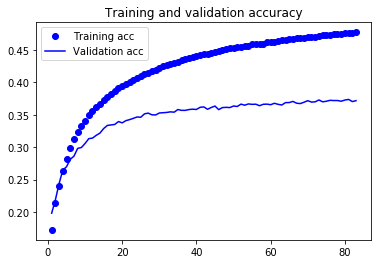

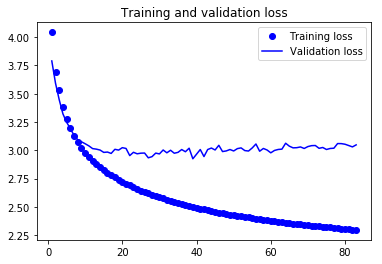

best validation accuracy:  0.37364999794960024


In [404]:
early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.001,
                              patience=10,
                              verbose=1, mode='auto')


history = model.fit(X_train_indices, 
                    y_train_idx, 
                    validation_data = (X_dev_indices, y_dev_idx),
                    epochs = 100, 
                    batch_size = 4096, 
                    shuffle=True,
                    callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

Hmm, even with two 128-unit LSTM layers, the model using the GloVe pretrained word embeddings seems to do worse than the simple embedding layer using our own embeddings. It's possible that in using pretrained embeddings we're discarding some  information, in that not all of the words are being recognised in the downloaded embeddings. (Hashtags, most obviously).

It would be instructive here to re-run the LSTM model using the simple (i.e. non-pretrained) embedding layer.

In [365]:
print ("Pre-trained word embeddings, avg indices per tweet:", np.count_nonzero(X_train_indices, axis=1).mean())
print ("New word embeddings, avg indices per tweet:", np.count_nonzero(x_train_sequences_1, axis=1).mean())

Pre-trained word embeddings, avg indices per tweet: 8.52013
New word embeddings, avg indices per tweet: 11.0151225


# LSTM model (no pre-trained encodings)

In [366]:
def simple_lstm_model(num_words,
                      n_output_classes, 
                      n_embedding_dims = 16, 
                      lstm_1_size=128,
                      dropout1_rate = 0.2,
                      lstm_2_size=128,
                      dropout2_rate = 0.2,
                      max_sequence_length = 20, 
                      lambd = 0.0):

    model = Sequential()

    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 
    model.add(LSTM(lstm_1_size, return_sequences=True))
    model.add(Dropout(dropout1_rate))
    model.add(LSTM(lstm_2_size))
    model.add(Dropout(dropout2_rate))
    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

Train on 400000 samples, validate on 20000 samples
Epoch 1/100
400000/400000 [==============================] - 12s 30us/step - loss: 3.9680 - acc: 0.1750 - val_loss: 3.6517 - val_acc: 0.2163
Epoch 2/100
400000/400000 [==============================] - 10s 24us/step - loss: 3.4756 - acc: 0.2535 - val_loss: 3.3542 - val_acc: 0.2608
Epoch 3/100
400000/400000 [==============================] - 10s 25us/step - loss: 3.2028 - acc: 0.2964 - val_loss: 3.2164 - val_acc: 0.2934
Epoch 4/100
400000/400000 [==============================] - 10s 24us/step - loss: 3.0575 - acc: 0.3229 - val_loss: 3.1199 - val_acc: 0.3104
Epoch 5/100
400000/400000 [==============================] - 10s 25us/step - loss: 2.9483 - acc: 0.3468 - val_loss: 3.0269 - val_acc: 0.3333
Epoch 6/100
400000/400000 [==============================] - 10s 25us/step - loss: 2.8612 - acc: 0.3659 - val_loss: 2.9711 - val_acc: 0.3454
Epoch 7/100
400000/400000 [==============================] - 10s 25us/step - loss: 2.7893 - acc: 0.3804

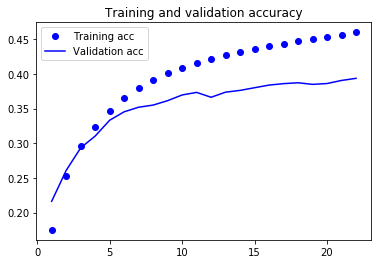

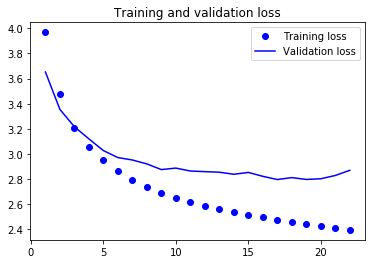

best validation accuracy:  0.3937499975681305


In [367]:
clear_session()

model = simple_lstm_model(num_words,
                          n_output_classes, 
                          n_embedding_dims = 100,
                          lstm_1_size = 128,
                          dropout1_rate = 0.5,   
                          lstm_2_size = 128,
                          dropout2_rate = 0.5,  
                          max_sequence_length = maxlen,
   #                       dense1_size = 128,               
                                  
                          lambd = 0.0025)                




early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences_1, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 100,
                     batch_size = 4096,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))